<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/23_chatbot_korean_transformer_06222023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항|	상세기준|내 평가|
|--|--|--|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|o|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|o|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|	한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|o|

- Transformer
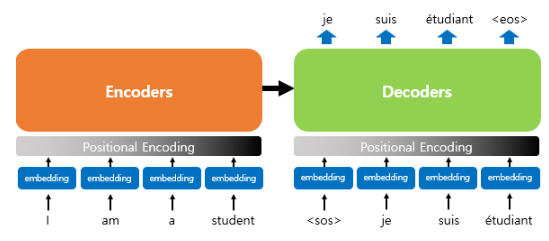

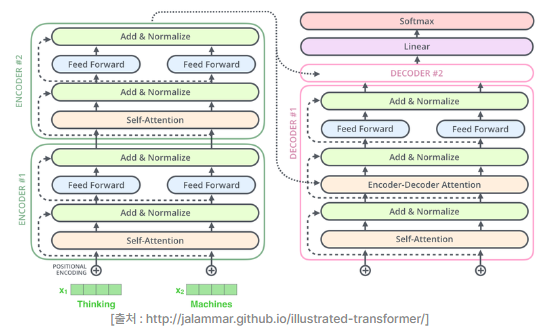

# Import Library

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")

슝=3


# 1 Get Data

In [ ]:
mkdir -p ~/aiffel/transformer_chatbot/data/

In [ ]:
!ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
# https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


# 2 Preprocess Data

In [ ]:
file_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'

data = pd.read_csv(file_path)
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


,Q,A,label
6800,싸구려 인생,누구도 당신의 인생을 평가할 수 없어요.,1
5061,핸드폰 너무 많이 해,그래서 저를 만날 수 있죠.,0
4661,친구랑 있으면 내가 작아져,당신은 생각보다 큰 사람이에요.,0
976,너무 추워서 시베리아 같아,어서 따듯한 곳으로 가세요,0
8952,결혼식 날짜 잡으려고,축하드려요.,2
2158,부자 백수 하고 싶어,그게 최고죠.,0
8048,정말 아직 너무 사랑합니다 잡고 싶습니다,다시 잡는다면 후회할 거예요.,1
7273,욕을 퍼붓고 왓어,마음이 후련하길 바랍니다.,1
8304,참아야겠지,가끔은 내키는 대로 해보세요.,1
9922,사랑이 뭘까 궁금해,저도 상당히 궁금하네요.,2


In [ ]:
data['label'].unique()

array([0, 1, 2])

In [ ]:
data.groupby(['label']).count()

,Q,A
label,,
0,5290,5290
1,3570,3570
2,2963,2963


In [ ]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [ ]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 전처리 함수

def preprocess_sentence(sentence):
#   sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z|ㄱ-ㅎ|ㅏ-ㅣ|가-힣|?.!,0-9]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [ ]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(data):
    inputs, outputs =[],[]

    q_sentences = data['Q']
    a_sentences = data['A']

    for i,j in zip(q_sentences, a_sentences):
        inputs.append(preprocess_sentence(i))
        outputs.append(preprocess_sentence(j))

    return inputs, outputs

print("슝=3")

슝=3


In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(data)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print('{} : {}'.format(questions[1], answers[1]))
print('{} : {}'.format(questions[21], answers[21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
1지망 학교 떨어졌어 : 위로해 드립니다 .
가스비 장난 아님 : 다음 달에는 더 절약해봐요 .


## Preprocess pararrel data
1. TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  
    단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  
    각 토큰을 고유한 정수로 인코딩 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

### make vocabulary

In [ ]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


### Encoding(to integer) & Padding

In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1번째 질문 샘플: {}'.format(tokenizer.encode(questions[1])))
print('정수 인코딩 후의 1번째 답변 샘플: {}'.format(tokenizer.encode(answers[1])))

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 1번째 질문 샘플: [7963, 47, 917, 7946, 997, 1715]
정수 인코딩 후의 1번째 답변 샘플: [1828, 5499, 1]
정수 인코딩 후의 21번째 질문 샘플: [5762, 610, 2490, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7510, 7, 6273, 97, 1]


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [ ]:
questions_token, answers_token = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print('{} : {}'.format(questions_token[1], answers_token[1]))
print('{} : {}'.format(questions_token[21], answers_token[21]))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823
[8170 7963   47  917 7946  997 1715 8171    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0] : [8170 1828 5499    1 8171    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8170 5762  610 2490 4163 8171    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0] : [8170 2356 7510    7 6273   97    1 8171    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Teacher Forcing

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_token,
        'dec_inputs': answers_token[:, :-1]
    },
    {
        'outputs': answers_token[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# 3 Get Model

In [ ]:
# padding masking
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # tf.cast : d.type을 바꾸는 함수
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [ ]:
# look ahead masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("이해못함")

이해못함


In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


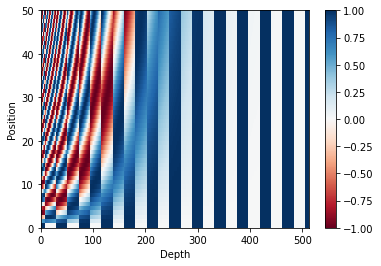

In [ ]:
# 최대 문장 길이 : 50, 워드 임베딩 차원 : 512
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

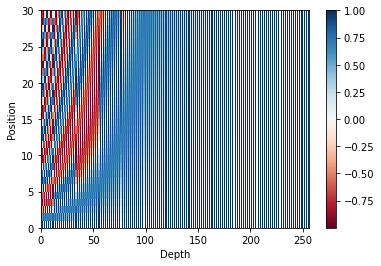

In [ ]:
# 최대 문장 길이 : 30, 워드 임베딩 차원 : 256
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [ ]:
# multi head attention

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))
# 0인 부분은 1로 아니면 0으로 바뀌었네

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
# Encoder layer = self attention(multi head attention) + feed forward neural network
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [ ]:
# Transformer Encoder

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [ ]:
# Decoder layer
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [ ]:
# Decoder
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## Model

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    8918016     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

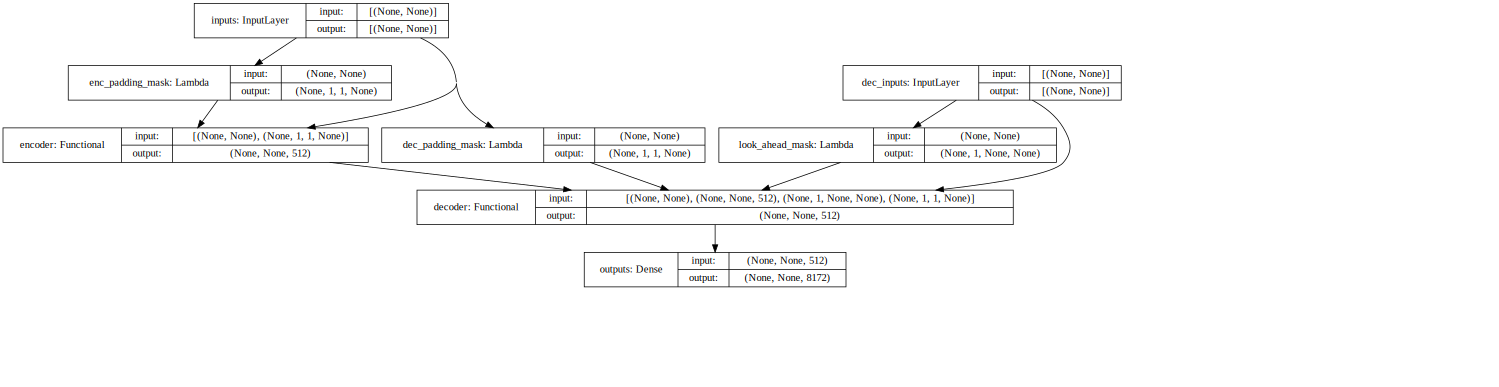

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=96).create(prog='dot', format='svg'))

## Loss function

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


## Learning Rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

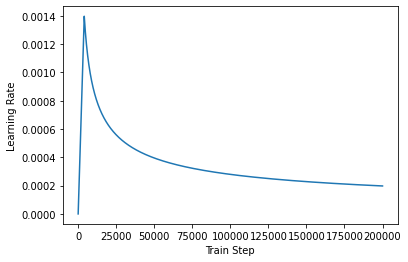

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Model Compile

In [ ]:
from tensorflow.keras import callbacks

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# check_point_cb = callbacks.ModelCheckpoint('chatbot_model',
#                                            save_format='tf')
early_stopping_cb = callbacks.EarlyStopping(patience=3,
                                            monitor='accuracy',
                                            restore_best_weights=True)
print("슝=3")

슝=3


## Train

In [ ]:
EPOCHS = 100
history1 = model.fit(dataset, epochs=EPOCHS, callbacks=[early_stopping_cb])

Epoch 1/100
185/185 [==============================] - 32s 125ms/step - loss: 1.3438 - accuracy: 0.0293
Epoch 2/100
185/185 [==============================] - 24s 127ms/step - loss: 1.0623 - accuracy: 0.0497
Epoch 3/100
185/185 [==============================] - 23s 125ms/step - loss: 0.9657 - accuracy: 0.0527
Epoch 4/100
185/185 [==============================] - 23s 124ms/step - loss: 0.9047 - accuracy: 0.0561
Epoch 5/100
185/185 [==============================] - 23s 125ms/step - loss: 0.8420 - accuracy: 0.0594
Epoch 6/100
185/185 [==============================] - 23s 125ms/step - loss: 0.7708 - accuracy: 0.0651
Epoch 7/100
185/185 [==============================] - 23s 125ms/step - loss: 0.6916 - accuracy: 0.0739
Epoch 8/100
185/185 [==============================] - 23s 125ms/step - loss: 0.6054 - accuracy: 0.0835
Epoch 9/100
185/185 [==============================] - 23s 125ms/step - loss: 0.5158 - accuracy: 0.0944
Epoch 10/100
185/185 [==============================] - 23s 125m

In [ ]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy'])


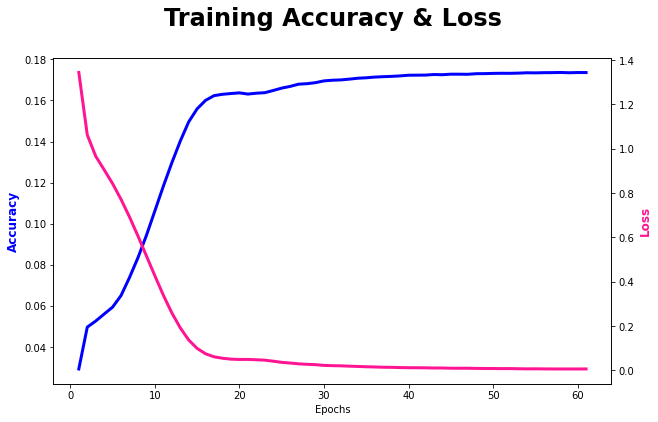

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
loss = history_dict1['loss']

epochs = range(1, len(acc) + 1)

fig, ax1= plt.subplots(figsize=(10, 6), facecolor="w")

ax1.plot(epochs, acc, lw=3, color='blue')

ax2 = ax1.twinx()

ax2.plot(epochs, loss, lw=3, color='deeppink')

# ax1.legend(['Accuracy'], loc='best', prop=dict(weight='bold'))
# ax2.legend(['Loss'], loc=(0.85, 0.93), prop=dict(weight='bold'))
ax1.set_title('Training Accuracy & Loss', fontsize=24, fontweight="bold", pad=32)

ax1.set_ylabel("Accuracy", fontsize=12, fontweight="bold", color='blue')
ax2.set_ylabel("Loss", fontsize=12, fontweight="bold", color='deeppink')
ax1.set_xlabel("Epochs")

plt.show()

In [ ]:
from keras.models import load_model
model.save_weights('chatbot_model')
# model.save("chatbot_model.h5")

In [ ]:
load_status = model.load_weights('chatbot_model')

# `assert_consumed` can be used as validation that all variable values have been
# restored from the checkpoint. See `tf.train.Checkpoint.restore` for other
# methods in the Status object.
load_status.assert_consumed()

# 4 Test Chat-Bot

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [ ]:
sentence_generation('졸리다.')

입력 : 졸리다.
출력 : 잠을 깨요 ! 기운 내요 ! !


'잠을 깨요 ! 기운 내요 ! !'

In [ ]:
sentence_generation("집이 깨끗하네요")

입력 : 집이 깨끗하네요
출력 : 무슨 이유일이 있었나봐요 .


'무슨 이유일이 있었나봐요 .'

In [ ]:
sentence_generation('아침에 일찍 일어나는 방법이 있나요?')

입력 : 아침에 일찍 일어나는 방법이 있나요?
출력 : 조금 더 일찍 잠을 자보세요 .


'조금 더 일찍 잠을 자보세요 .'

In [ ]:
sentence_generation("가끔 무력해질 때가 있어요")

입력 : 가끔 무력해질 때가 있어요
출력 : 지금처럼 현실을 인정하세요 .


'지금처럼 현실을 인정하세요 .'

# Review
- 한글이므로 전처리시에 한글에 대한 것을 추가하였음.
- accuracy와 loss 값이 안정적으로 수렴한 듯 보임.
- 대화 내용이 어색한 것도 있지만 대체로 괜찮은 대답을 함.  

|입력|출력|
|--|--|
|졸리다|잠을 깨요 ! 기운 내요 ! !|
|집이 깨끗하네요|무슨 이유일이 있었나봐요 .|
|아침에 일찍 일어나는 방법이 있나요?|조금 더 일찍 잠을 자보세요 .|
|가끔 무력해질 때가 있어요|지금처럼 현실을 인정하세요 .|

- 문제를 해결해주려는 의도의 문장이 생성이 됨.